In [1]:
num_epochs = 50

In [2]:
# Import the data for each company
import pandas as pd

#Empresa
df = pd.read_csv('TLEVISACPO.csv')
df

#Define the target
target = "Cierre"

df = df.drop(['Fecha','% var.','Vol.'], axis=1)
df

,Cierre,Apertura,Máximo,Mínimo
0,8.67,8.69,8.84,8.54
1,8.70,8.66,8.80,8.46
2,8.74,8.88,9.11,8.71
3,8.82,9.22,9.27,8.71
4,9.16,9.09,9.29,9.03
...,...,...,...,...
1143,44.07,43.60,44.44,43.32
1144,43.59,44.38,44.38,42.92
1145,44.48,44.85,45.03,44.22
1146,45.23,44.99,45.45,44.64


In [3]:
#Define the features
features = list(df.columns.difference([]))
features

['Cierre', 'Apertura', 'Máximo', 'Mínimo']

In [4]:
#Define the training and test percentages
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
#Normalize the data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
#LSTM training
from utils import SequenceDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

#Sets the seed for generating random numbers
torch.manual_seed(101) 

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [7]:
#Define functions to train/test the model
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [8]:
#Define the parameters to train the model
from utils import ShallowRegressionLSTM
from torch import nn

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,num_epochs):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 0.7553693604196094
Test accuracy: 1.323855480528029

Epoch 0
---------
Train loss: 0.7283404789856701
Train accuracy: 1.3729840528625479
Test loss: 0.2996271863990322
Test accuracy: 3.337479746982183
Epoch 1
---------
Train loss: 0.18290333798226743
Train accuracy: 5.467365791653137
Test loss: 0.07989850277776131
Test accuracy: 12.515863422311766
Epoch 2
---------
Train loss: 0.04022093247708196
Train accuracy: 24.86261387172998
Test loss: 0.055409400489371166
Test accuracy: 18.04744657807957
Epoch 3
---------
Train loss: 0.028212426684775267
Train accuracy: 35.445247821055474
Test loss: 0.042353670004725966
Test accuracy: 23.610649061191406
Epoch 4
---------
Train loss: 0.02066450611648545
Train accuracy: 48.39192164433454
Test loss: 0.0312544159205318
Test accuracy: 31.995376365534344
Epoch 5
---------
Train loss: 0.015001589216929512
Train accuracy: 66.65915988124144
Test loss: 0.024239423952065135
Test accuracy: 41.25493561579633
Epoch 6
---------

In [9]:
#Save the cmodel
torch.save(model.state_dict(), "./cmodelTLEVISACPO" )

In [10]:
#Define the function to predict using the model
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [11]:
#Compare the real value vs. the predicted value
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Cierre  Model forecast
0       8.67        8.687830
1       8.70        8.674719
2       8.74        8.742355
3       8.82        8.844036
4       9.16        9.003563
...      ...             ...
1143   44.07       43.917519
1144   43.59       43.810364
1145   44.48       44.420471
1146   45.23       44.978600
1147   45.13       45.034538

[1149 rows x 2 columns]


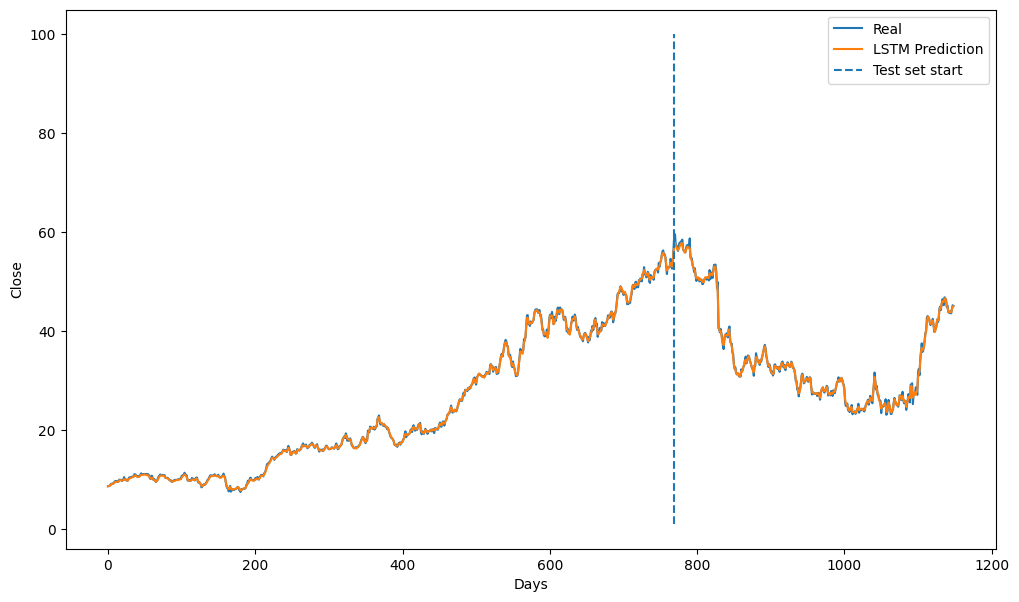

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 100, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

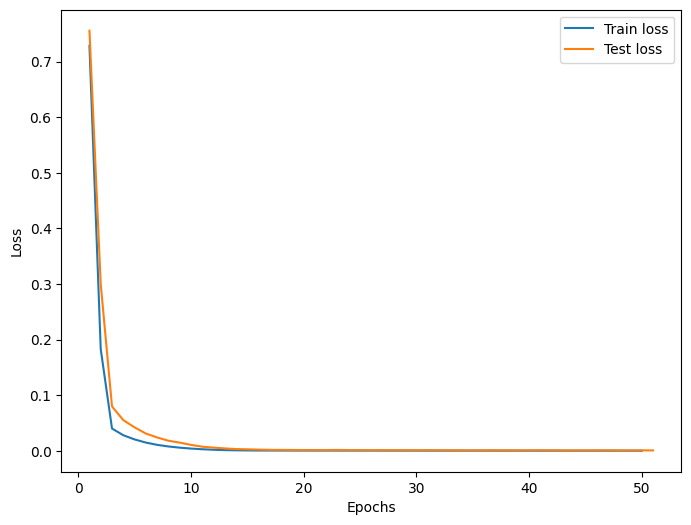

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), classical_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), classical_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
#Quantum prediction
from utils import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits = 4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [15]:
#Train the quantum model
import time

quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 1.023995603675388
Test accuracy: 0.9765665973116281
Execution time 16.813023328781128
Epoch 0
---------
Train loss: 0.049735354118590105
Train accuracy: 20.106381206766144
Test loss: 0.014961981341630707
Test accuracy: 66.83562113899126
Execution time 79.63182425498962
Epoch 1
---------
Train loss: 0.002846786546154491
Train accuracy: 351.2609244477189
Test loss: 0.006464166171774048
Test accuracy: 154.69660026786318
Execution time 79.4693431854248
Epoch 2
---------
Train loss: 0.0016986172719892824
Train accuracy: 588.6794797988663
Test loss: 0.004760155395091469
Test accuracy: 210.0727622789207
Execution time 79.69378447532654
Epoch 3
---------
Train loss: 0.0012229290380547772
Train accuracy: 817.6420746235887
Test loss: 0.0029283359762627384
Test accuracy: 341.47920873318776
Execution time 79.56485033035278
Epoch 4
---------
Train loss: 0.0010075671199850347
Train accuracy: 992.3912174636117
Test loss: 0.0026471952187358655
Test accuracy: 377.7440

In [16]:
#Save the qmodel
torch.save(Qmodel.state_dict(), "./qmodelTLEVISACPO" )

In [17]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Cierre  Model forecast
0       8.67        8.569002
1       8.70        8.539682
2       8.74        8.721935
3       8.82        8.836551
4       9.16        9.017760
...      ...             ...
1143   44.07       43.931404
1144   43.59       43.702240
1145   44.48       44.495216
1146   45.23       45.095440
1147   45.13       45.023788

[1149 rows x 2 columns]


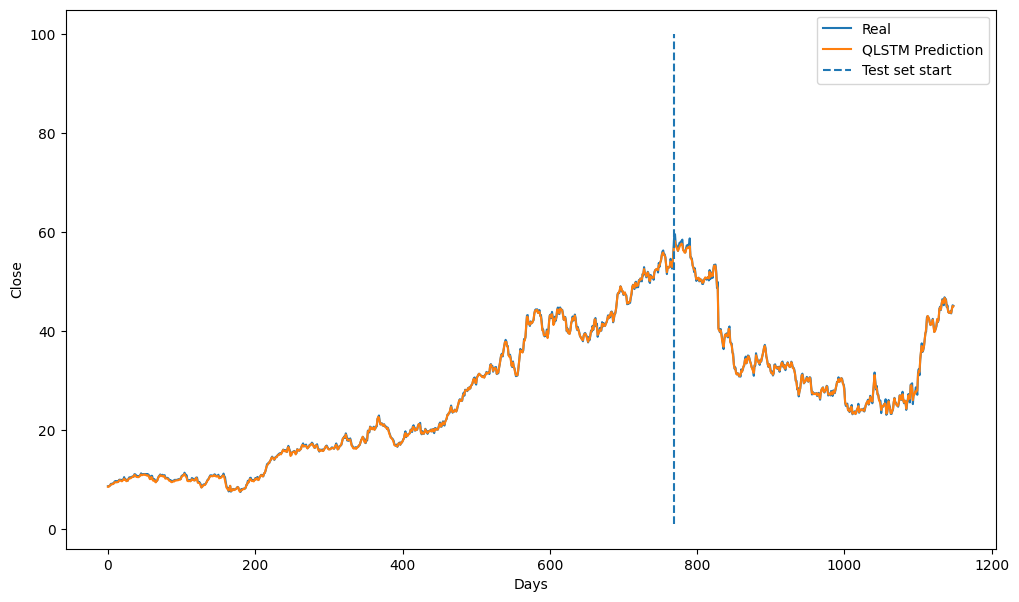

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 100, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

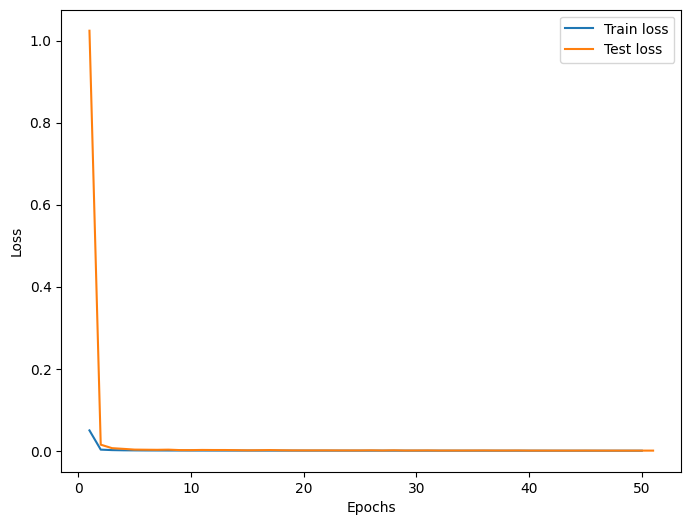

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), quantum_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), quantum_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

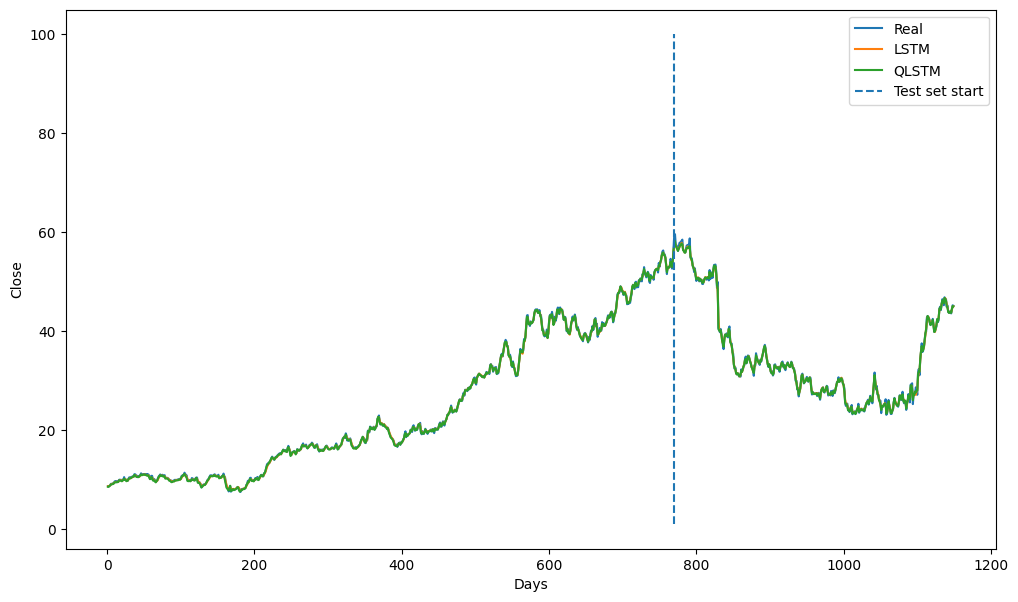

In [23]:
##Comparison between classical and quantum
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(df) + 2), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1, len(df) + 2), df_out["Model forecast"], label = "LSTM")
plt.plot(range(1, len(df) + 2), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 100, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()